# Fabled Lands Graph Generator

Creates a map of connections between sections in the _Fabled Lands_ series.

In [1]:
# !pip install graphviz

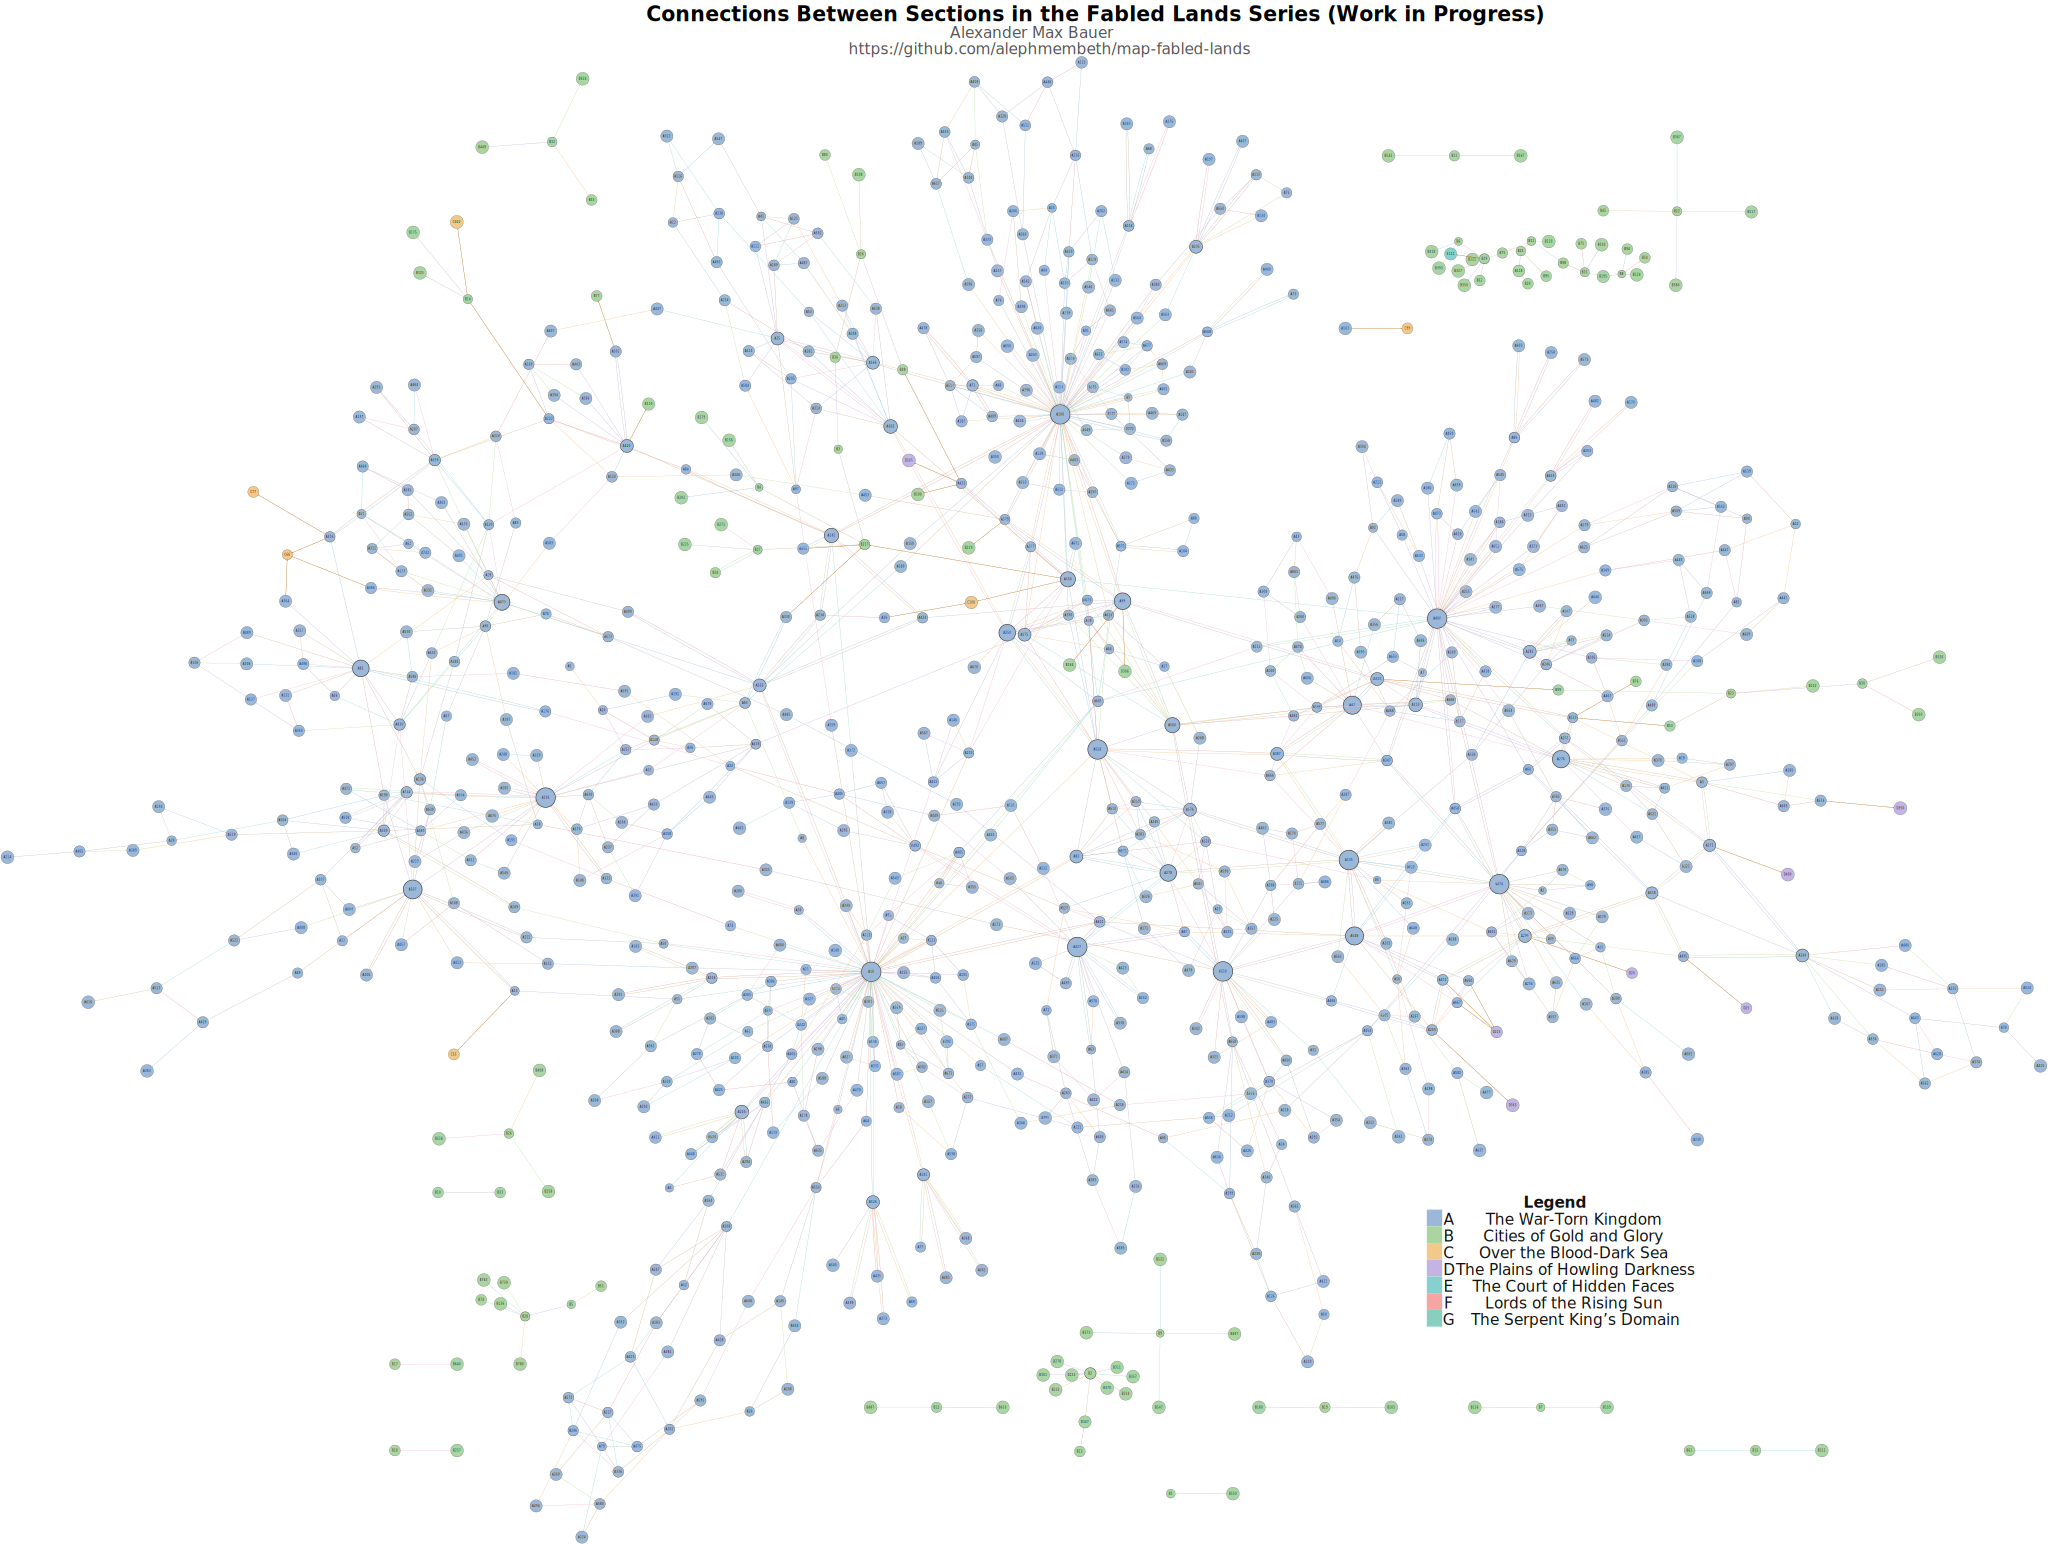

Saved as: map_fabled_lands.pdf


In [2]:
import os
import re
import glob
import random
import pandas as pd
from collections import Counter
from graphviz import Digraph
from IPython.display import SVG, display

# Set random seed
random.seed(42)

# Set data path
data_path = "Data"

# Map book letter codes to their full titles
book_names_map = {
    "A": "The War-Torn Kingdom",
    "B": "Cities of Gold and Glory",
    "C": "Over the Blood-Dark Sea",
    "D": "The Plains of Howling Darkness",
    "E": "The Court of Hidden Faces",
    "F": "Lords of the Rising Sun",
    "G": "The Serpent King’s Domain",
}

def get_book_letter(node_name: str) -> str:
    m = re.search(r'[A-Ga-g]', node_name)
    if not m:
        return None
    return m.group(0).upper()

def sortkey(n: str):
    try:
        letter = get_book_letter(n) or n[0].upper()
        num = int(re.sub(r'^[A-Ga-g]+', '', n))
        return (letter, num)
    except Exception:
        return (get_book_letter(n) or n[0].upper(), n)

# Load edges
edges = []
for filepath in glob.glob(os.path.join(data_path, "*.csv")):
    df = pd.read_csv(filepath)
    cols_lower = {c.lower(): c for c in df.columns}
    s_col = cols_lower["source"]
    t_col = cols_lower["target"]
    for a, b in zip(df[s_col], df[t_col]):
        if pd.isna(a) or pd.isna(b):
            continue
        a = str(a).strip().lower()
        b = str(b).strip().lower()
        if not a or not b:
            continue
        edges.append((a, b))

# Remove self-loops
edges = [(u, v) for (u, v) in edges if u != v]

# Collect unique nodes
nodes = {u for e in edges for u in e}

# Compute node degrees
degree = Counter([u for u, v in edges] + [v for u, v in edges])

# Extract and sort book identifiers
books_lower = sorted({(get_book_letter(n) or n[0].upper()).lower() for n in nodes})

# Set colors
book_fill = {
    "A": "#9BB8D9",    # blue
    "B": "#A8D5A2",    # green
    "C": "#F3C88B",    # orange
    "D": "#C4B4E3",    # violet
    "E": "#87D0D0",    # turquoise
    "F": "#F5A6A3",    # red
    "G": "#88CFC0",    # teal
}

edge_palette = [
    "#A3C3E2",         # blue
    "#F6C38B",         # orange
    "#B9E2A0",         # green
    "#E8A6A4",         # red
    "#C6B5E0",         # violet
    "#D4B896",         # brown
    "#F2B8D2",         # pink
    "#BDBDBD",         # gray
    "#9ED9D6",         # turquoise
]

cross_edge_color = "#b35a00"

# Set density (between 0 and 1; controls spacing in the layout)
DENSITY = 0.55

def lerp(a, b, t):
    return a + (b - a) * t

# Compute layout constants
K                = f"{lerp(1.6, 3.2, DENSITY):.2f}"      # Global spring constant
REPULSE          = f"{lerp(1.2, 2.6, DENSITY):.2f}"      # Node repulsion force
OV_SCALE         = f"{lerp(1.1, 2.2, DENSITY):.2f}"      # Overlap scaling
SEP              = f"+{lerp(0.8, 2.0, DENSITY):.1f}"     # Node separation
ESEP             = f"+{lerp(0.8, 2.0, DENSITY):.1f}"     # Edge separation
EDGE_LEN         = f"{lerp(1.4, 2.4, DENSITY):.1f}"      # Typical edge length
CROSS_EDGE_LEN   = f"{lerp(1.8, 3.2, DENSITY):.1f}"      # Cross-book edges
NODE_WH_BASE     = lerp(0.30, 0.36, DENSITY)             # Node size

# Initialize graph
g = Digraph("fabled_lands", format="svg", engine="sfdp")

# Add title and author credit
g.attr(
    label = (
        '<<TABLE BORDER = "0" CELLBORDER = "0" CELLSPACING = "0">'
        '<TR><TD><FONT POINT-SIZE = "100"><B>Connections Between Sections in the Fabled Lands Series (Work in Progress)</B></FONT></TD></TR>'
        '<TR><TD><FONT POINT-SIZE = "75" COLOR = "#555555">Alexander Max Bauer</FONT></TD></TR>'
        '<TR><TD><FONT POINT-SIZE = "75" COLOR = "#555555">https://github.com/alephmembeth/map-fabled-lands</FONT></TD></TR>'
        '</TABLE>>'
    ),
    labelloc = "t",
    labeljust = "c",
    fontsize = "12",
    fontname = "Inter"
)

# Set global layout and rendering parameters
g.attr(
    splines = "line",
    overlap = "scale",
    overlap_scaling = OV_SCALE,
    sep = SEP,
    esep = ESEP,
    K = K,
    repulsiveforce = REPULSE,
    maxiter = "20000",
    fontname = "Inter"
)

# Set edge parameters
g.attr("edge",
    arrowsize = "0.3",
    arrowhead = "vee",
    color = "#555555",
    penwidth = "1.2",
    len = EDGE_LEN
)

# Set node parameters
g.attr("node",
    shape = "circle",
    style = "filled",
    color = "#4a5568",
    fontcolor = "#111111",
    fontname = "Inter",
    fontsize = "12",
    width = f"{NODE_WH_BASE:.2f}",
    height = f"{NODE_WH_BASE:.2f}",
    fixedsize = "false"
)

# Insert nodes with degree-based size and border
for n in sorted(nodes, key = sortkey):
    b_upper = get_book_letter(n) or n[0].upper()

    deg = degree[n]
    size = NODE_WH_BASE + 0.05 * min(deg, 20)
    border = 0.8 + 0.15 * min(deg, 15)

    g.node(
        n,
        label = n.upper(),
        style = "filled",
        fillcolor = book_fill.get(b_upper, "#9BB8D9"),
        color = "#333333",
        penwidth = f"{border:.2f}",
        width = f"{size:.2f}",
        height = f"{size:.2f}",
        fixedsize = "false"
    )

# Insert legend
legend_rows = []

for k in sorted(book_names_map.keys()):
    v = book_names_map[k]
    color = book_fill.get(k, "#4F81BD")
    legend_rows.append(
        f'<TR>'
        f'<TD WIDTH = "75" HEIGHT = "75" FIXEDSIZE = "FALSE" BGCOLOR="{color}"></TD>'
        f'<TD>{k}</TD>'
        f'<TD>{v}</TD>'
        f'</TR>'
    )
legend_label = (
    '<<TABLE BORDER = "0" CELLBORDER = "1" CELLSPACING = "0">'
    '<TR><TD COLSPAN = "3" BALIGN = "LEFT"><B>Legend</B></TD></TR>'
    + "".join(legend_rows) +
    '</TABLE>>'
)

legend = Digraph(name = "cluster_legend")

legend.attr(
    label = "",
    style = "rounded",
    color = "#9bb5d7",
    penwidth = "1.2",
    fontname = "Inter",
    fontsize = "75",
    labeljust = "l",
    rank = "sink"
)

legend.attr("node",
    shape = "plaintext",
    fixedsize = "false",
    width = "0",
    height = "0",
    fontname = "Inter",
    fontsize = "75"
)

legend.node("legend_table", label = legend_label, style = "", color = "none")

g.subgraph(legend)

# Bundle duplicate edges and weight penwidth by frequency
edge_counts = Counter(edges)

for (u, v), cnt in edge_counts.items():
    bu = get_book_letter(u) or u[0].upper()
    bv = get_book_letter(v) or v[0].upper()
    pw = 1.2 + 0.4 * (min(cnt, 8) ** 0.7)

    if bu != bv:
        g.edge(u, v,
            color = cross_edge_color,
            penwidth = f"{pw:.2f}",
            len = CROSS_EDGE_LEN,
            arrowhead = "vee"
        )
    else:
        g.edge(u, v,
            color = random.choice(edge_palette),
            penwidth = f"{pw:.2f}",
            len = EDGE_LEN,
            arrowhead = "vee"
        )

# Render and display
svg_data = g.pipe(format = "svg").decode("utf-8")

display(SVG(svg_data))

# Export
pdf_path = g.render(
    filename = "map_fabled_lands",
    format = "pdf",
    cleanup = True
)

print("Saved as:", pdf_path)